In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.font_manager as fm
import koreanize_matplotlib

# 폰트 경로 확인 및 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # 설치된 폰트 경로
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

# 한글 깨짐 방지 - 마이너스 기호 처리
plt.rcParams['axes.unicode_minus'] = False

In [2]:
group_df = pd.read_parquet('gs://final_project_enuyu/data/final_project/votes/accounts_group.parquet')

school_df = pd.read_parquet('gs://final_project_enuyu/data/final_project/votes/accounts_school.parquet')

user_df = pd.read_parquet('gs://final_project_enuyu/data/final_project/votes/accounts_user.parquet')

questionset_df = pd.read_parquet('gs://final_project_enuyu/data/final_project/votes/polls_questionset.parquet')



In [3]:
# 2. school_info 구성: group_id → school_id 연결 + 학교 정보 merge
group_df = group_df.rename(columns={'id': 'group_id'})  # group_id 명확히
school_info = pd.merge(group_df, school_df[['id', 'school_type', 'student_count']],
                       left_on='school_id', right_on='id', how='left').drop(columns='id')

# 3. user_df 전처리 (필요한 컬럼만 + 날짜/운영자 필터링)
user_df = user_df[['id', 'created_at', 'gender', 'group_id', 'is_staff', 'is_superuser']]
user_df['created_at'] = pd.to_datetime(user_df['created_at'])

# 8월 이전 가입자 중 운영자 제외
user_df = user_df.loc[
    (user_df['created_at'] < '2023-08-01') &
    (user_df['is_staff'] != 1) &
    (user_df['is_superuser'] != 1)
]

# 4. group_id 기준으로 스쿨 인포와 머지
user_school_df = pd.merge(user_df, school_info, on='group_id', how='left')

# 5. 질문 데이터 전처리
question_df = (
    questionset_df[['id', 'status', 'created_at', 'user_id']]
    .assign(created_at=lambda df: pd.to_datetime(df['created_at']))
    .query("created_at < '2023-08-01' and status != 'B'")
    .assign(day=lambda df: df['created_at'].dt.floor('D'))  # 하루 단위로
    .drop_duplicates(subset=['user_id', 'day'])  # 중복 제거
)

# 6. 질문 기록과 유저-학교 정보 병합
question_record = pd.merge(
    questionset_df.drop(columns='id'),
    user_school_df.rename(columns={'id': 'user_id'})[['user_id', 'gender', 'school_id']],
    on='user_id',
    how='left'
)

### 질문에 참여한 유저가 속한 학교의 개수

In [4]:
question_record['school_id'].nunique()

10

In [5]:
# 학교 ID 목록
question_record['school_id'].dropna().unique()

array([ 271., 4516.,  369.,  352., 1478., 5520., 5491., 5372., 1719.,
       4426.])

### 질문에 참여한 유저 수

In [7]:
question_record['user_id'].nunique()

4972

In [8]:
user_df['id'].nunique()

673183

In [9]:
total_user_count = user_df['id'].nunique()
print(f"전체 가입 유저 수: {total_user_count}")

전체 가입 유저 수: 673183


### 질문 기능 노출된 학교에 속한 유저 수(분모)

In [10]:
# 질문에 참여한 school_id 목록
participating_schools = question_record['school_id'].dropna().unique()

# 해당 학교에 속한 유저 수 (중복 없이)
participating_user_count = user_school_df[
    user_school_df['school_id'].isin(participating_schools)
]['id'].nunique()

print(f"질문 기능 노출된 학교 소속 유저 수 (분모): {participating_user_count}")

질문 기능 노출된 학교 소속 유저 수 (분모): 5074


In [11]:
actual_participation_rate = 4972 / participating_user_count
print(f"질문 기능 노출 유저 기준 참여율: {actual_participation_rate:.2%}")

질문 기능 노출 유저 기준 참여율: 97.99%


In [12]:
# 투표기록 불러오가
userquestionrecord_df = pd.read_parquet('gs://final_project_enuyu/data/final_project/votes/accounts_userquestionrecord.parquet')


In [13]:
# 1. userquestionrecord_df 전처리
userquestionrecord_df['created_at'] = pd.to_datetime(userquestionrecord_df['created_at'])

# 2. user_id 기준으로 학교/성별 정보 merge
record_with_school = pd.merge(
    userquestionrecord_df,
    user_school_df.rename(columns={'id': 'user_id'})[['user_id', 'gender', 'school_id']],
    on='user_id',
    how='left'
)

# 3. question_id 기준으로 질문 정보 merge (질문 생성일, 질문 유저 등)
questionset_df = questionset_df.rename(columns={'id': 'question_id'})  # 병합을 위해 id → question_id
record_merged = pd.merge(
    record_with_school,
    questionset_df[['question_id', 'user_id', 'created_at', 'status']],
    on='question_id',
    how='left',
    suffixes=('', '_question')
)

# 4. 날짜 필터링 (2023-08-01 이전 참여만)
record_merged = record_merged[record_merged['created_at'] < '2023-08-01']


### 응답률

In [14]:
# 1. 날짜 필터링 (2023년 5월~7월)
df_5to7 = record_merged[
    (record_merged['created_at'] >= '2023-05-01') &
    (record_merged['created_at'] < '2023-08-01')
]

# 2. 열람한 데이터만 필터링
read_df = df_5to7[df_5to7['has_read'] == 1]

# 3. 그중 응답한 데이터 (answer_status != 'N')
responded_df = read_df[read_df['answer_status'] != 'N']

# 4. 응답률 계산
response_rate = len(responded_df) / len(read_df) if len(read_df) > 0 else 0

# 5. 결과 출력
print(f"[2023년 5~7월] 열람자 기준 응답률 (answer_status != 'N'): {response_rate:.2%}")


[2023년 5~7월] 열람자 기준 응답률 (answer_status != 'N'): 17.84%


In [15]:
responded_df

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times,gender,school_id,user_id_question,created_at_question,status_question
31250,1492826,C,2023-05-01 04:15:15,855041,219,857609,1866074,1,A,2023-05-07 02:37:03,0,0,M,271.0,NaN,NaT,NaN
31473,1501045,C,2023-05-01 04:41:58,856487,228,849692,1841933,1,A,2023-05-06 08:55:49,0,0,M,271.0,NaN,NaT,NaN
32045,1511111,C,2023-05-01 05:17:08,855041,231,857262,1853099,1,A,2023-05-07 02:36:24,0,0,M,271.0,NaN,NaT,NaN
32544,1522678,C,2023-05-01 05:57:14,856665,232,857926,1950452,1,A,2023-05-07 06:01:02,0,0,M,271.0,NaN,NaT,NaN
32555,1522873,C,2023-05-01 05:57:49,855041,313,855817,1966325,1,A,2023-05-07 02:36:15,0,0,F,271.0,NaN,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1182397,150784898,C,2023-06-07 15:41:57,887991,2356,883374,191553936,1,A,2023-06-07 15:42:58,0,0,M,4516.0,NaN,NaT,NaN
1182400,150785481,C,2023-06-07 15:42:37,887991,3822,883374,191553939,1,A,2023-06-07 15:43:09,0,0,M,4516.0,NaN,NaT,NaN
1182563,150825226,C,2023-06-07 16:41:50,869580,2285,877117,192477279,1,A,2023-06-07 16:43:00,0,0,F,4516.0,NaN,NaT,NaN
1182570,150825637,I,2023-06-07 16:42:40,887714,2357,869580,190234929,1,A,2023-06-07 17:40:52,0,1,F,4516.0,NaN,NaT,NaN


In [16]:
# 1. 날짜 필터링 (2023년 5~7월)
df_5to7 = record_merged[
    (record_merged['created_at'] >= '2023-05-01') &
    (record_merged['created_at'] < '2023-08-01')
]

# 2. 전체 투표 발신 수
total_records = len(df_5to7)

# 3. 열람된 수
read_df = df_5to7[df_5to7['has_read'] == 1]
read_count = len(read_df)

# 4. 열람되지 않은 수
unread_count = total_records - read_count

# 5. 열람 후 응답 수 (answer_status != 'N')
responded_count = len(read_df[read_df['answer_status'] != 'N'])

# 6. 열람 후 미응답 수
no_response_count = read_count - responded_count

# 7. 응답률 (열람자 기준)
response_rate = responded_count / read_count if read_count > 0 else 0
no_response_rate = no_response_count / read_count if read_count > 0 else 0

# 8. 출력
print("[2023년 5~7월 요약 통계]")
print(f"전체 투표 발신 수: {total_records:,} (100%)")
print(f"→ 열람된 수: {read_count:,} ({read_count / total_records:.2%})")
print(f"→ 열람되지 않은 수: {unread_count:,} ({unread_count / total_records:.2%})")
print(f"→ 열람 후 응답한 수: {responded_count:,} ({response_rate:.2%})")
print(f"→ 열람 후 미응답 수: {no_response_count:,} ({no_response_rate:.2%})")

[2023년 5~7월 요약 통계]
전체 투표 발신 수: 1,181,418 (100%)
→ 열람된 수: 670,208 (56.73%)
→ 열람되지 않은 수: 511,210 (43.27%)
→ 열람 후 응답한 수: 119,536 (17.84%)
→ 열람 후 미응답 수: 550,672 (82.16%)


### 투표율

In [17]:
# 1. 질문 기능 노출된 학교 목록
participating_schools = question_record['school_id'].dropna().unique()

# 2. record_merged에서 해당 학교 유저 + 5~7월 데이터만 필터링
filtered_votes = record_merged[
    (record_merged['school_id'].isin(participating_schools)) &
    (record_merged['created_at'] >= '2023-05-01') &
    (record_merged['created_at'] < '2023-08-01')
]

In [18]:
filtered_votes = filtered_votes[filtered_votes['user_id'].notna()]
# 1. 날짜 컬럼 생성
filtered_votes['vote_date'] = pd.to_datetime(filtered_votes['created_at']).dt.date

# 2. user_id 누락 제거 (필수)
filtered_votes = filtered_votes[filtered_votes['user_id'].notna()]

# 3. 유저 기준 중복 제거 (같은 날 여러 건 → 1건)
unique_daily_voters = filtered_votes.drop_duplicates(subset=['user_id', 'vote_date'])

# 4. 일자별 유저 수 집계
daily_vote_count = unique_daily_voters.groupby('vote_date')['user_id'].count().reset_index(name='vote_count')

# 5. 전체 유저 수 (질문 노출 학교 소속 유저 수)
# participating_user_count는 이미 정의된 상태라고 가정
daily_vote_count['vote_rate'] = daily_vote_count['vote_count'] / participating_user_count

# 6. 누락 없는 날짜 캘린더 생성
calendar = pd.DataFrame({'vote_date': pd.date_range(start='2023-05-01', end='2023-07-31')})
calendar['vote_date'] = calendar['vote_date'].dt.date  # datetime.date 형으로 맞춤

# 7. 누락 없는 테이블 병합
daily_vote_count_full = pd.merge(calendar, daily_vote_count, on='vote_date', how='left').fillna(0)

# 8. 출력 확인
daily_vote_count_full

,vote_date,vote_count,vote_rate
0,2023-05-01,325,0.064052
1,2023-05-02,413,0.081395
2,2023-05-03,756,0.148995
3,2023-05-04,820,0.161608
4,2023-05-05,1248,0.245960
...,...,...,...
87,2023-07-27,14,0.002759
88,2023-07-28,14,0.002759
89,2023-07-29,17,0.003350
90,2023-07-30,11,0.002168


### 데일리 리텐션

In [21]:
# 전체 기간 동안 한 번이라도 투표(응답)한 고유 학생 수
total_voted_student_count = filtered_votes['user_id'].nunique()
print(f"투표한 학생 수(고유): {total_voted_student_count:,}")

투표한 학생 수(고유): 4,835


In [30]:
# 1. 유저별 최초 투표일 추출
first_vote = (
    filtered_votes.groupby('user_id')['vote_date']
    .min()
    .reset_index()
    .rename(columns={'vote_date': 'first_vote_date'})
)

# 2. 병합 및 datetime 형 변환
retention_df = filtered_votes.merge(first_vote, on='user_id', how='left')
retention_df['vote_date'] = pd.to_datetime(retention_df['vote_date'])
retention_df['first_vote_date'] = pd.to_datetime(retention_df['first_vote_date'])

# 3. Day 0 기준 며칠 뒤인지 계산
retention_df['days_since_first'] = (retention_df['vote_date'] - retention_df['first_vote_date']).dt.days

# 4. 유저별 (user_id, days_since_first) 중복 제거
retention_unique = retention_df.drop_duplicates(subset=['user_id', 'days_since_first'])

# 5. 리텐션 계산
retention_curve = (
    retention_unique.groupby('days_since_first')['user_id']
    .nunique()
    .reset_index(name='retained_users')
)

# 6. 리텐션율 추가
total_users = first_vote['user_id'].nunique()
retention_curve['retention_rate'] = retention_curve['retained_users'] / total_users


# 7. 출력 확인
retention_curve.head(10) # Day 0 ~ Day 9

,days_since_first,retained_users,retention_rate
0,0,4835,1.000000
1,1,4376,0.905067
2,2,4133,0.854809
3,3,3819,0.789866
4,4,3421,0.707549
5,5,3117,0.644674
6,6,2781,0.575181
7,7,2429,0.502378
8,8,2138,0.442192
9,9,1804,0.373113


1. Day 1 리텐션이 90% 이상으로 굉장히 높다 → 사용자 초기 반응 매우 우수

2. Day 7 기준 약 50% 유지 → 일주일 후에도 절반은 계속 활동 중

3. Day 9 기준 37.3% → 자연 감소 추세는 있지만, 이탈률이 급격하진 않음

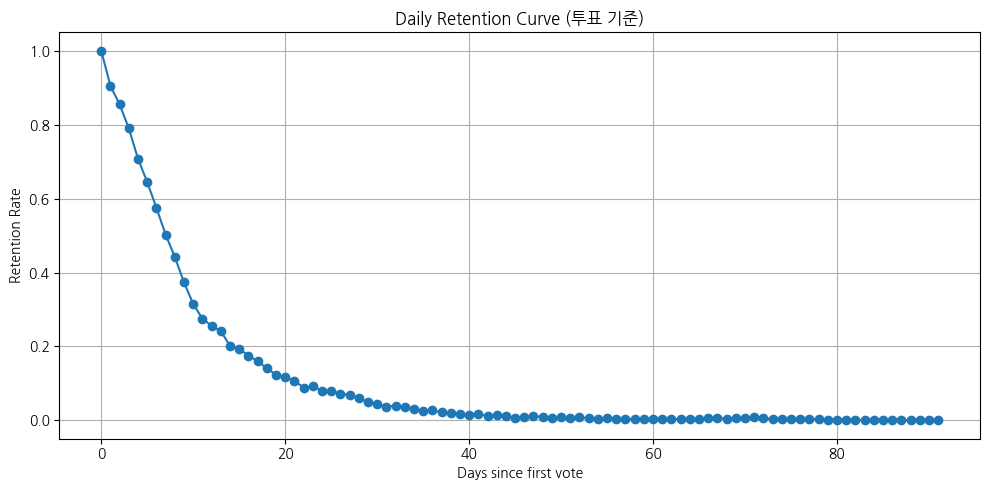

In [27]:

plt.figure(figsize=(10, 5))
plt.plot(retention_curve['days_since_first'], retention_curve['retention_rate'], marker='o')
plt.title('Daily Retention Curve (투표 기준)')
plt.xlabel('Days since first vote')
plt.ylabel('Retention Rate')
plt.grid(True)
plt.tight_layout()
plt.show()


In [31]:
# 1. 투표일 컬럼을 datetime.date 형식으로 보장
filtered_votes['vote_date'] = pd.to_datetime(filtered_votes['created_at']).dt.date

# 2. 유저별 첫 투표일 구하기
user_first_vote = (
    filtered_votes.groupby('user_id')['vote_date']
    .min()
    .reset_index()
    .rename(columns={'vote_date': 'first_vote_date'})
)

# 3. 날짜별 신규 유저 수 집계 (즉, 각 코호트 시작 인원 수)
cohort_new_users = (
    user_first_vote.groupby('first_vote_date')['user_id']
    .nunique()
    .reset_index(name='new_users')
)

# 4. 확인
display(cohort_new_users.head())


,first_vote_date,new_users
0,2023-05-01,325
1,2023-05-02,103
2,2023-05-03,388
3,2023-05-04,168
4,2023-05-05,436


In [32]:
# 1. 유저별 첫 투표일 추출
user_first_vote = (
    filtered_votes.groupby('user_id')['vote_date']
    .min()
    .reset_index()
    .rename(columns={'vote_date': 'first_vote_date'})
)

# 2. 기존 투표 기록과 병합 → 유저가 어떤 코호트(첫날)에 속했는지 알 수 있음
retention_df = filtered_votes.merge(user_first_vote, on='user_id', how='left')

# 3. days_since_first 계산 (Day 0, Day 1, ...)
retention_df['vote_date'] = pd.to_datetime(retention_df['vote_date'])
retention_df['first_vote_date'] = pd.to_datetime(retention_df['first_vote_date'])
retention_df['days_since_first'] = (retention_df['vote_date'] - retention_df['first_vote_date']).dt.days

# 4. 중복 제거 (같은 날 여러 번 투표한 건 제외)
retention_unique = retention_df.drop_duplicates(subset=['user_id', 'days_since_first'])

# 5. 코호트별 N일 후 유저 수 집계
cohort_retention = (
    retention_unique.groupby(['first_vote_date', 'days_since_first'])['user_id']
    .nunique()
    .reset_index(name='retained_users')
)

# 6. 피벗 → 매트릭스 형태로 변환
retention_matrix = cohort_retention.pivot(
    index='first_vote_date',
    columns='days_since_first',
    values='retained_users'
).fillna(0).astype(int)

# (선택) 비율로 보고 싶으면 아래처럼 나눔
retention_matrix_rate = retention_matrix.div(retention_matrix[0], axis=0).round(4)

# 결과 확인
display(retention_matrix.head())
display(retention_matrix_rate.head())

days_since_first,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
first_vote_date,,,,,,,,,,,,,,,,,,,,,
2023-05-01,325,310,285,228,229,222,195,154,128,118,...,0,2,0,4,2,1,3,3,2,4
2023-05-02,103,83,74,71,70,61,47,45,47,35,...,0,0,1,1,0,0,2,0,1,0
2023-05-03,388,350,356,339,317,264,235,194,163,129,...,2,0,2,0,0,0,0,3,0,0
2023-05-04,168,156,152,141,107,93,83,71,56,40,...,0,0,0,0,0,0,0,0,0,0
2023-05-05,436,409,374,331,259,248,191,164,138,146,...,1,0,1,0,1,0,0,0,0,0


days_since_first,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
first_vote_date,,,,,,,,,,,,,,,,,,,,,
2023-05-01,1.0,0.9538,0.8769,0.7015,0.7046,0.6831,0.6000,0.4738,0.3938,0.3631,...,0.0000,0.0062,0.0000,0.0123,0.0062,0.0031,0.0092,0.0092,0.0062,0.0123
2023-05-02,1.0,0.8058,0.7184,0.6893,0.6796,0.5922,0.4563,0.4369,0.4563,0.3398,...,0.0000,0.0000,0.0097,0.0097,0.0000,0.0000,0.0194,0.0000,0.0097,0.0000
2023-05-03,1.0,0.9021,0.9175,0.8737,0.8170,0.6804,0.6057,0.5000,0.4201,0.3325,...,0.0052,0.0000,0.0052,0.0000,0.0000,0.0000,0.0000,0.0077,0.0000,0.0000
2023-05-04,1.0,0.9286,0.9048,0.8393,0.6369,0.5536,0.4940,0.4226,0.3333,0.2381,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2023-05-05,1.0,0.9381,0.8578,0.7592,0.5940,0.5688,0.4381,0.3761,0.3165,0.3349,...,0.0023,0.0000,0.0023,0.0000,0.0023,0.0000,0.0000,0.0000,0.0000,0.0000


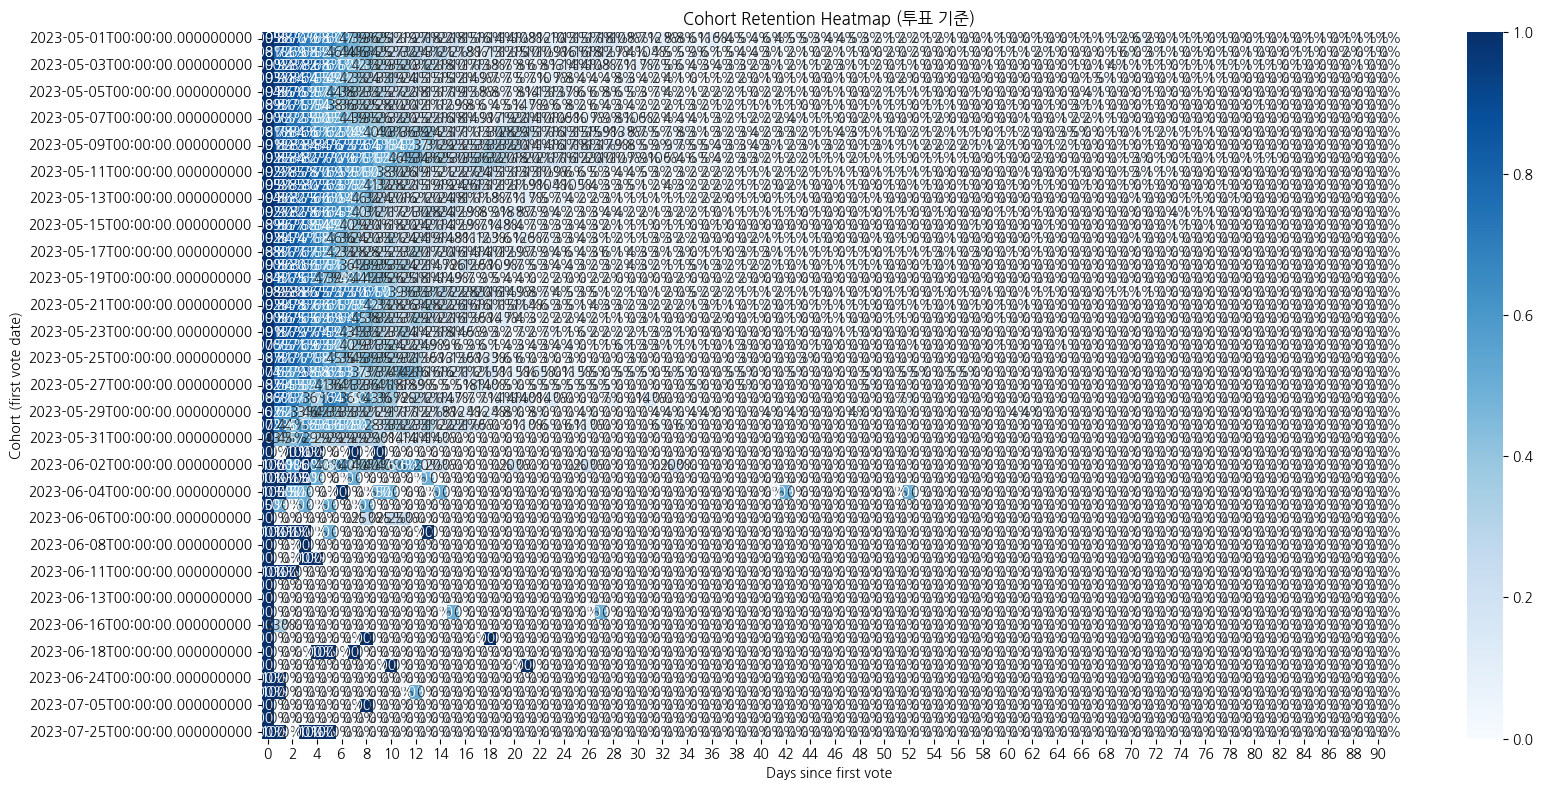

In [34]:
plt.figure(figsize=(17, 8))
sns.heatmap(retention_matrix_rate, cmap="Blues", annot=True, fmt=".0%", cbar=True)
plt.title("Cohort Retention Heatmap (투표 기준)")
plt.xlabel("Days since first vote")
plt.ylabel("Cohort (first vote date)")
plt.tight_layout()
plt.show()


### 5월 1일 ~ 6월 7일 코호트까지만

In [35]:
# 1. 유저별 최초 투표일 계산 (코호트 기준)
user_first_vote = (
    filtered_votes.groupby('user_id')['vote_date']
    .min()
    .reset_index()
    .rename(columns={'vote_date': 'first_vote_date'})
)

# 2. 병합하여 코호트 정보 부여
retention_df = filtered_votes.merge(user_first_vote, on='user_id', how='left')

# 3. 날짜 차이 계산
retention_df['vote_date'] = pd.to_datetime(retention_df['vote_date'])
retention_df['first_vote_date'] = pd.to_datetime(retention_df['first_vote_date'])
retention_df['days_since_first'] = (retention_df['vote_date'] - retention_df['first_vote_date']).dt.days

# 4. 중복 제거 (유저가 특정 일자에 중복 투표했더라도 1건만 카운트)
retention_unique = retention_df.drop_duplicates(subset=['user_id', 'days_since_first'])

# 5. ❗️5월 1일 ~ 6월 7일 사이의 코호트만 필터링
retention_unique = retention_unique[
    (retention_unique['first_vote_date'] >= '2023-05-01') &
    (retention_unique['first_vote_date'] <= '2023-06-07')
]

# 6. 코호트별 잔존 유저 수 집계
cohort_retention = (
    retention_unique.groupby(['first_vote_date', 'days_since_first'])['user_id']
    .nunique()
    .reset_index(name='retained_users')
)

# 7. 피벗 테이블 (매트릭스 형태)
retention_matrix = cohort_retention.pivot(
    index='first_vote_date',
    columns='days_since_first',
    values='retained_users'
).fillna(0).astype(int)

# 8. (선택) 리텐션율 계산
retention_matrix_rate = retention_matrix.div(retention_matrix[0], axis=0).round(4)

# 9. 결과 확인
display(retention_matrix.head())
display(retention_matrix_rate.head())


days_since_first,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
first_vote_date,,,,,,,,,,,,,,,,,,,,,
2023-05-01,325,310,285,228,229,222,195,154,128,118,...,0,2,0,4,2,1,3,3,2,4
2023-05-02,103,83,74,71,70,61,47,45,47,35,...,0,0,1,1,0,0,2,0,1,0
2023-05-03,388,350,356,339,317,264,235,194,163,129,...,2,0,2,0,0,0,0,3,0,0
2023-05-04,168,156,152,141,107,93,83,71,56,40,...,0,0,0,0,0,0,0,0,0,0
2023-05-05,436,409,374,331,259,248,191,164,138,146,...,1,0,1,0,1,0,0,0,0,0


days_since_first,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
first_vote_date,,,,,,,,,,,,,,,,,,,,,
2023-05-01,1.0,0.9538,0.8769,0.7015,0.7046,0.6831,0.6000,0.4738,0.3938,0.3631,...,0.0000,0.0062,0.0000,0.0123,0.0062,0.0031,0.0092,0.0092,0.0062,0.0123
2023-05-02,1.0,0.8058,0.7184,0.6893,0.6796,0.5922,0.4563,0.4369,0.4563,0.3398,...,0.0000,0.0000,0.0097,0.0097,0.0000,0.0000,0.0194,0.0000,0.0097,0.0000
2023-05-03,1.0,0.9021,0.9175,0.8737,0.8170,0.6804,0.6057,0.5000,0.4201,0.3325,...,0.0052,0.0000,0.0052,0.0000,0.0000,0.0000,0.0000,0.0077,0.0000,0.0000
2023-05-04,1.0,0.9286,0.9048,0.8393,0.6369,0.5536,0.4940,0.4226,0.3333,0.2381,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2023-05-05,1.0,0.9381,0.8578,0.7592,0.5940,0.5688,0.4381,0.3761,0.3165,0.3349,...,0.0023,0.0000,0.0023,0.0000,0.0023,0.0000,0.0000,0.0000,0.0000,0.0000


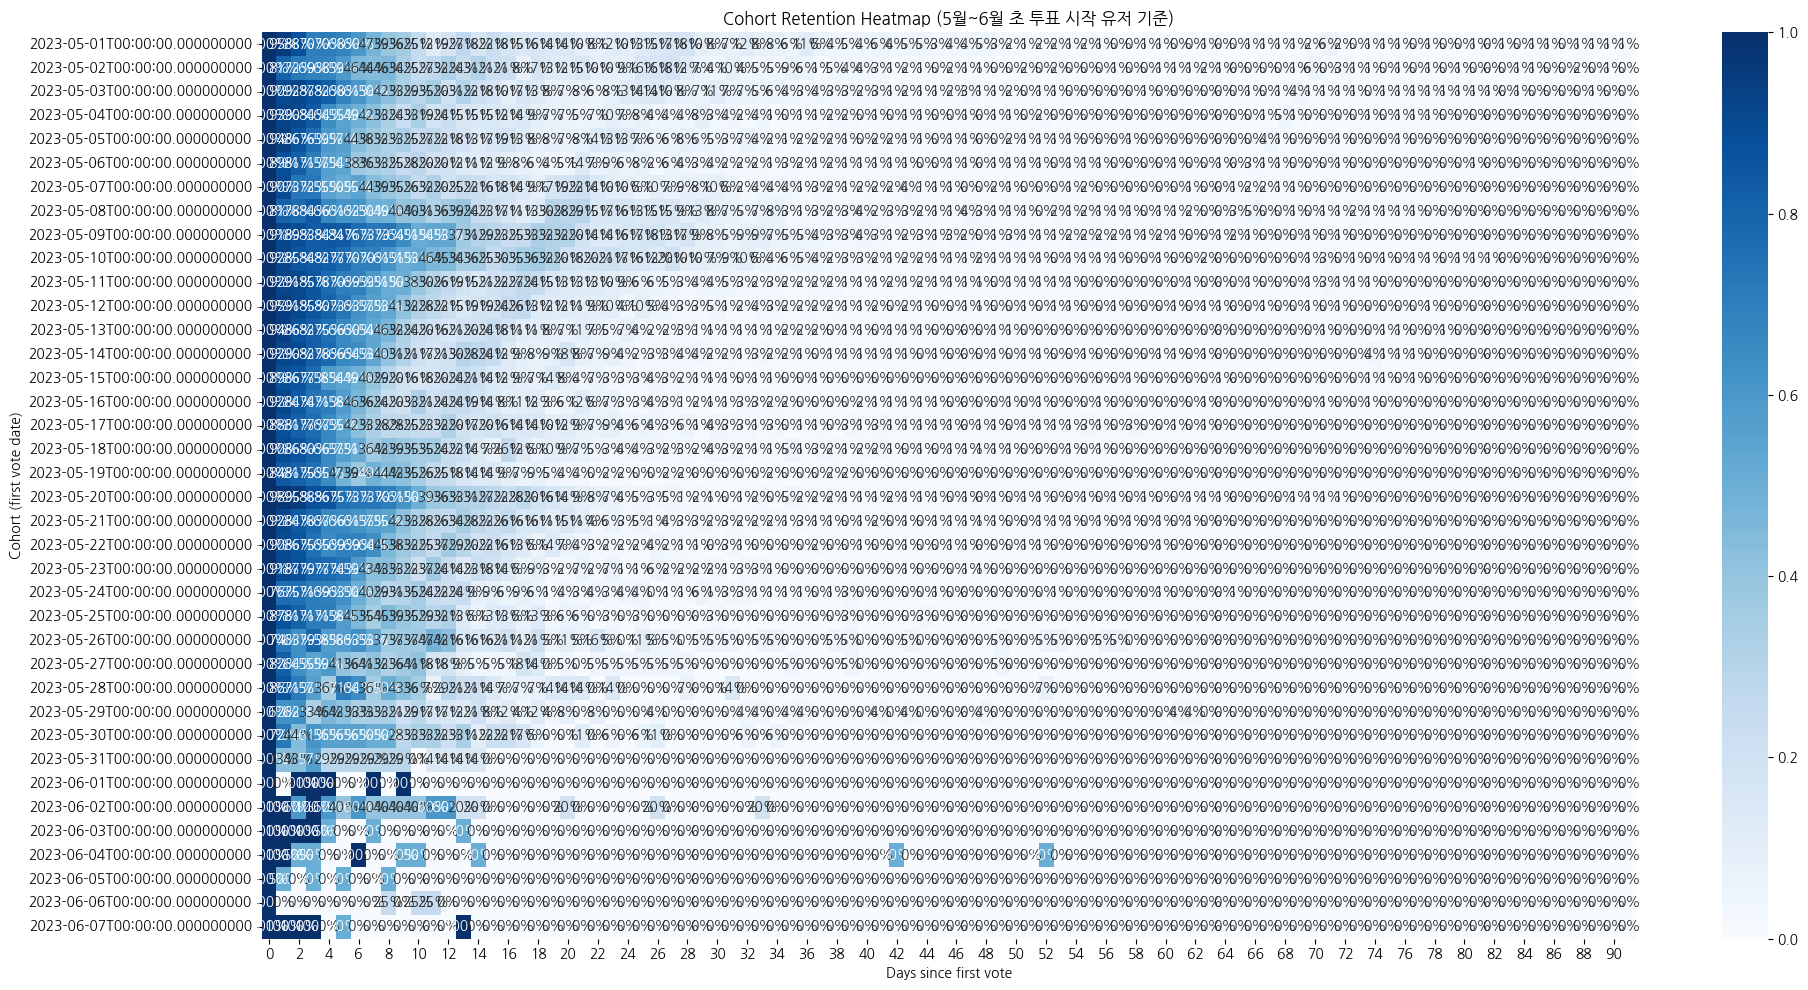

In [39]:
plt.figure(figsize=(20, 10))
sns.heatmap(retention_matrix_rate, cmap="Blues", annot=True, fmt=".0%", cbar=True)
plt.title("Cohort Retention Heatmap (5월~6월 초 투표 시작 유저 기준)")
plt.xlabel("Days since first vote")
plt.ylabel("Cohort (first vote date)")
plt.tight_layout()
plt.show()

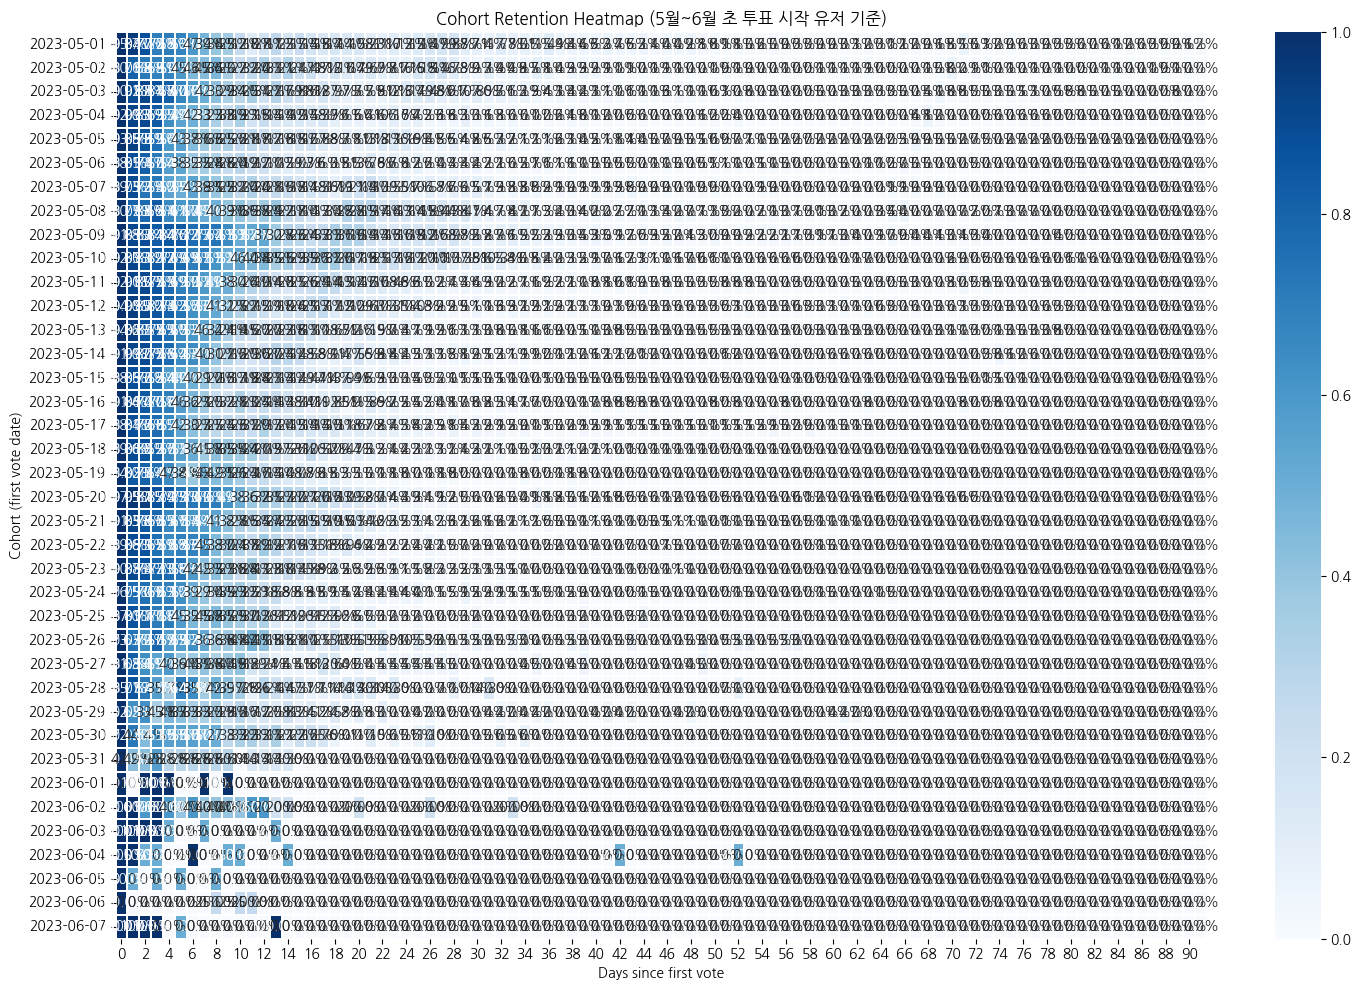

In [46]:
# 날짜 인덱스 포맷 깔끔하게
retention_matrix_rate.index = pd.to_datetime(retention_matrix_rate.index).strftime('%Y-%m-%d')

plt.figure(figsize=(15, 10))
sns.heatmap(
    retention_matrix_rate,
    cmap="Blues",
    annot=True,
    fmt=".1%",  # 소수점 1자리 % 형식
    linewidths=0.2,
    cbar=True
)

plt.title("Cohort Retention Heatmap (5월~6월 초 투표 시작 유저 기준)")
plt.xlabel("Days since first vote")
plt.ylabel("Cohort (first vote date)")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


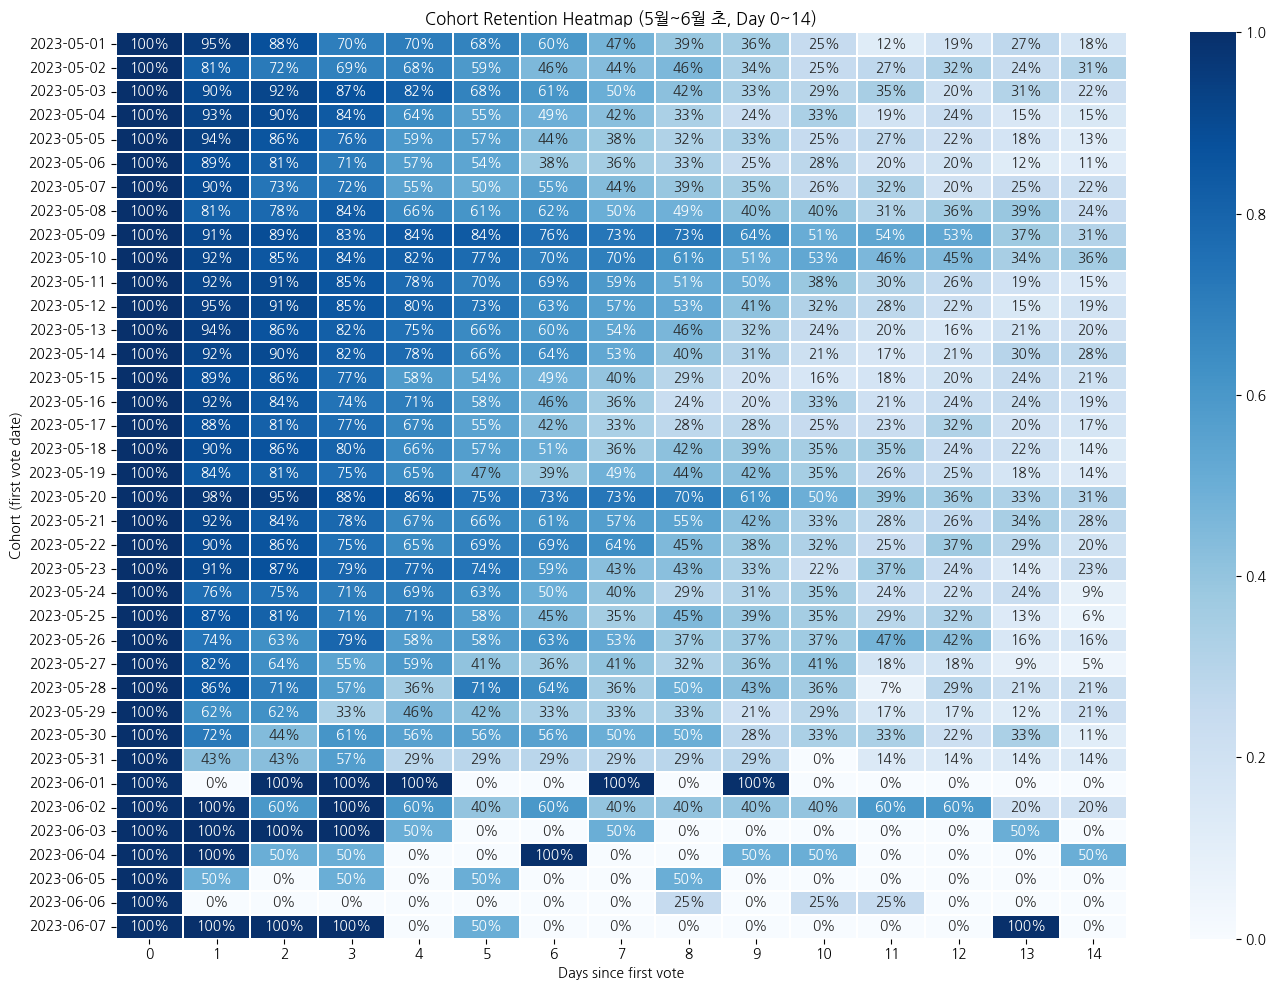

In [47]:

# 날짜 문자열로 포맷
retention_matrix_rate.index = pd.to_datetime(retention_matrix_rate.index).strftime('%Y-%m-%d')

# Day 0 ~ 14까지만 잘라서 가독성 확보
retention_matrix_trimmed = retention_matrix_rate.loc[:, :14]

# 히트맵 그리기 (숫자 보기 좋게)
plt.figure(figsize=(14, 10))
sns.heatmap(
    retention_matrix_trimmed,
    cmap="Blues",
    annot=True,
    fmt=".0%",           # 정수 % 형태
    linewidths=0.3,
    cbar=True
)

plt.title("Cohort Retention Heatmap (5월~6월 초, Day 0~14)")
plt.xlabel("Days since first vote")
plt.ylabel("Cohort (first vote date)")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
